# Building features

In this notebook, we extract building features from OpenStreetMap and height data from
the swissSURFACE3D Raster and swissALTI3D products provided by swisstopo's STAC API.
This allows us to obtain an open alternative to the ["LIDAR: Hauteurs des bâtiments"](
https://viageo.ch/md/e5adf72f-3a92-6934-9960-8dec80eb570d) dataset provided by the
Administration cantonale vaudoise.

In [ ]:
import contextily as cx
import geopandas as gpd
import osmnx as ox
import pandas as pd
import rasterio as rio
import rasterstats
from tqdm import tqdm

from uhi_drivers_lausanne import stac_utils

OSMNX_TAGS = {"building": True}

tqdm.pandas()

In [ ]:
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"
stations_gdf_filepath = "../data/interim/stations-gdf.gpkg"
buffer_dists = [10, 30, 60, 90]
# select only 2019 because there is surface3d for 2019 only but alti3d for 2019 and 2021
surface3d_datetime = "2019/2019"
alti3d_datetime = "2019/2019"
dst_filepath = "../data/interim/bldg-features.csv"

## Get building footprints from OpenStreetMap

We start by getting the building footprints from OpenStreetMap using the `osmnx`
package for the extent of the agglomeration.

In [ ]:
# use iloc to get the agglomeration extent (the second item is the Leman lake)
agglom_extent_gser = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[0:1]

# we need to project the building footprints to the same CRS as the swissSURFACE3D and
# swissALTI3D products (which is EPSG:2056)
# we drop the "node" column to keep only the "way" and "relation" columns that
# correspond to polygon geometries
bldg_gdf = (
    ox.features_from_polygon(
        agglom_extent_gser.to_crs(ox.settings.default_crs).iloc[0], tags=OSMNX_TAGS
    )
    .to_crs(stac_utils.SWISSALTI3D_CRS)
    .drop("node", level="element_type")
    .reset_index(level="element_type")
)

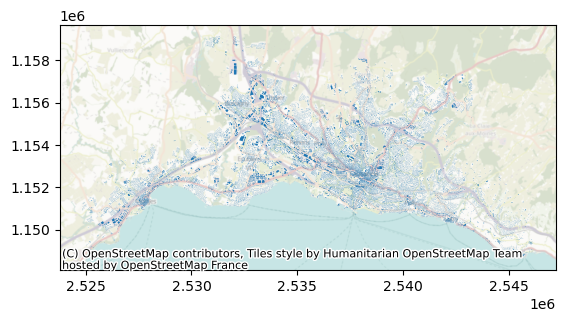

In [ ]:
ax = bldg_gdf.plot()
cx.add_basemap(ax, crs=bldg_gdf.crs, alpha=0.5)

## Get list of data needed from swisstopo's STAC API

We use the STAC API to get the building heights from the swissSURFACE3D and
swissALTI3D.

We first define a function to get the geo-data frame of tiles of a given collection:

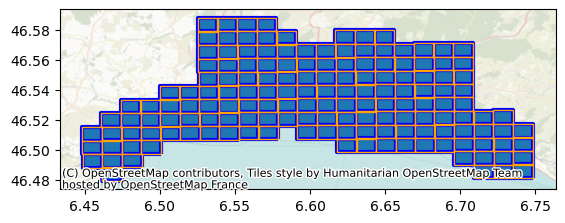

In [ ]:
agglom_extent_geom = agglom_extent_gser.to_crs(stac_utils.CLIENT_CRS).iloc[0]

client = stac_utils.SwissTopoClient()
surface3d_gdf = client.gdf_from_collection(
    stac_utils.SWISSSURFACE3D_RASTER_COLLECTION,
    extent_geom=agglom_extent_geom,
    datetime=surface3d_datetime,
    extension=".tif",
)

alti3d_gdf = client.gdf_from_collection(
    stac_utils.SWISSALTI3D_COLLECTION,
    extent_geom=agglom_extent_geom,
    datetime=alti3d_datetime,
    extension=".tif",
)

ax = surface3d_gdf.plot(edgecolor="blue", linewidth=3)
alti3d_gdf.plot(ax=ax, facecolor="none", edgecolor="orange")
cx.add_basemap(ax, crs=surface3d_gdf.crs, alpha=0.5)

## Extend building footprint geo-dataframe with height information

We now compute the building heights as zonal statistics. To that end, we first compute
a "building height raster" as the difference between the swissSURFACE3D (surface
height including natural and man-made objects) and swissALTI3D (digital elevation
model without vegetation and development). Then, we consider each building polygon as
a "zone" so that its height is the zonal average of the "building height raster".

In [ ]:
# surface3d and alti3d have the same tiling - actually, it could be derived from the
# filenames without need for (more expensive) spatial opreations
def get_bldg_heights(bldg_gdf, row, *, stats="mean"):
    with rio.open(row[stac_utils.SWISSSURFACE3D_RASTER_COLLECTION]) as src_surface3d:
        with rio.open(row[stac_utils.SWISSALTI3D_COLLECTION]) as src_alti3d:
            element_arr = src_surface3d.read(1) - src_alti3d.read(1)

        group_bldg_gser = bldg_gdf[bldg_gdf.intersects(row["geometry"])]["geometry"]
        # we could also do a try/except approach to catch rasterstats' ValueError
        if group_bldg_gser.empty:
            # # test if stats is list-like
            # if not pd.api.types.is_list_like(stats):
            #     stats = [stats]
            # return pd.DataFrame(columns=stats, index=[])
            # return `None` to avoid https://stackoverflow.com/questions/77254777/
            # alternative-to-concat-of-empty-dataframe-now-that-it-is-being-deprecated
            return None
        else:
            return pd.DataFrame(
                rasterstats.zonal_stats(
                    group_bldg_gser,
                    element_arr,
                    # we could also use `src_surface3d.transform` because it is the same
                    affine=src_surface3d.transform,
                    stats=stats,
                ),
                group_bldg_gser.index,
            )


# we need to project the gdf of tiles to the same CRS as the actual swissSURFACE3D and
# swissALTI3D products (again, EPSG:2056)
tile_gdf = (
    surface3d_gdf.sjoin(alti3d_gdf, how="inner", predicate="contains")
    .drop("index_right", axis=1)
    .to_crs(stac_utils.SWISSALTI3D_CRS)
)
# we could do a data frame apply approach returning a series of of building heights that
# correspond to a single zonal statistic (e.g., "mean"). However, we use concatenation
# because this would allow us to compute multiple zonal statistics for each row.
bldg_height_df = pd.concat(
    [
        get_bldg_heights(bldg_gdf, row)
        for _, row in tqdm(tile_gdf.iterrows(), total=tile_gdf.shape[0])
    ]
)

# merge duplicates (i.e., buildings that are in multiple tiles) taking their mean
# TODO: better approach?
bldg_height_df = bldg_height_df.groupby(bldg_height_df.index).mean()
bldg_height_df.head()

  0%|                                                         | 0/156 [00:00<?, ?it/s]/home/martibosch/mambaforge/envs/uhi-drivers-lausanne/lib/python3.11/site-packages/rasterstats/io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(
100%|███████████████████████████████████████████████| 156/156 [11:37<00:00,  4.47s/it]


,mean
osmid,
153242,9.211792
324390,4.809050
324932,10.699439
324933,14.096398
325957,17.836756


Since the obtained (estimated) heights indexed by the `osmid`, it is straightforward
to add them as a column of the building footprint geo-data frame. We further select
only the columns of interest, and we remove the buildings with zero or negative
height - which are likely due to the mismatch between the building footprint dates and
the swissSURFACE3D and swissALTI3D dates (e.g., post-2019 buildings that are on OSM).

In [ ]:
bldg_gdf = bldg_gdf.assign(height=bldg_height_df["mean"])[["height", "geometry"]]
bldg_gdf = bldg_gdf[bldg_gdf["height"] > 0]
# Dump to a file
# bldg_gdf.to_file(dst_filepath)

## Compute building-related features

We finally use the building footprints and heights to compute features at each station
location for each buffer distance.

In [ ]:
# `stations_gdf` should already be in the same CRS as the buildings (EPSG:2056)
stations_gdf = gpd.read_file(stations_gdf_filepath)  # .to_crs(bldg_gdf.crs)
# we set the index to the station name because otherwise we lose this information in the
# `buffer` operation below
station_index_name = stations_gdf.columns.drop("geometry")[0]
stations_gdf = stations_gdf.set_index(station_index_name)

In [ ]:
def compute_area_vol(gdf, buffer_dist):
    return pd.Series(
        {
            f"bldg_area_{buffer_dist}": gdf["geometry"].area.sum(),
            f"bldg_volume_{buffer_dist}": (gdf["geometry"].area * gdf["height"]).sum(),
        }
    )


bldg_features_df = pd.concat(
    [
        stations_gdf.buffer(buffer_dist)
        .to_frame(name="geometry")
        .sjoin(bldg_gdf)
        .reset_index(station_index_name)
        .groupby(by=station_index_name)
        .apply(compute_area_vol, buffer_dist)
        for buffer_dist in buffer_dists
    ],
    axis="columns",
).fillna(0)

## Dump to a file

In [ ]:
bldg_features_df.to_csv(dst_filepath)